In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import nibabel as nib
import logging
import os
import sys
import shutil
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    CropForeground,
    NormalizeIntensity
)
from nilearn import image
import nilearn
from monai.data import NibabelReader
from monai.networks.blocks import ResidualUnit,Convolution
from torch import nn

In [2]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
data_path ='/workspace/raid/data/zubrikhina/datasets/COBRE_ICA_cleaned/'

In [5]:
label_path ="meta_data.tsv"

In [6]:
labels_data =pd.read_csv(label_path, delimiter="\t")
labels_data=labels_data.loc[labels_data['Dx'].isin(['No_Known_Disorder', 'Schizophrenia_Strict'])]
labels_data=labels_data[['Subjectid','Dx']].drop_duplicates()
labels_data['Dx']=labels_data['Dx'].map({'No_Known_Disorder': 0, 'Schizophrenia_Strict' :1})

In [7]:
data_fmriprep_path =Path(data_path)

In [8]:
data_fmriprep_path

PosixPath('/workspace/raid/data/zubrikhina/datasets/COBRE_ICA_cleaned')

In [9]:
images =[]
labels =[]
for raw in labels_data.iterrows():
        subj_id=raw[1]['Subjectid']
        label=raw[1]['Dx']
        brain_path =Path(f'{data_path}/sub-{subj_id}/fmri.nii')
        if brain_path.exists():
            images.append(brain_path)
            labels.append(label)

In [10]:
len(images)

152

In [11]:
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [12]:
# Define transforms
train_transforms = Compose([EnsureChannelFirst(),CropForeground(select_fn=lambda x: x > 0, margin=0),NormalizeIntensity(), Resize((32, 32, 32))])

val_transforms = Compose([EnsureChannelFirst(),CropForeground(select_fn=lambda x: x > 0, margin=0),NormalizeIntensity(), Resize((32, 32, 32))])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:-30], labels=labels[:-30], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-30:], labels=labels[-30:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, pin_memory=pin_memory)

/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


<class 'monai.data.meta_tensor.MetaTensor'> (2, 30, 32, 32, 32) tensor([[0., 1.],
        [0., 1.]]) torch.Size([2, 2])


In [13]:
example =next(iter(train_loader))

/opt/miniconda-latest/lib/python3.8/site-packages/monai/data/utils.py:766: UserWarning: Modifying image pixdim from [2. 2. 2. 1.] to [  2.           2.           2.         170.76592166]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


(array([[ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 32.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 31.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 30.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 29.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0.,  0.,  6., 24.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  3.,  5., 19.,  3.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  5., 21.,  2.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  4., 17.,  3.,  2.,  4.,  0.,  0.],
        [ 0.,  0.,  6.,  2., 16.,  3.,  3.,  0.,  1.,  1.],
        [ 0.,  3.,  1.,  3., 19.,  2.,  2.,  2.,  0.,  0.],
        [ 0.,  1.,  1.,  4., 22.,  3.,  

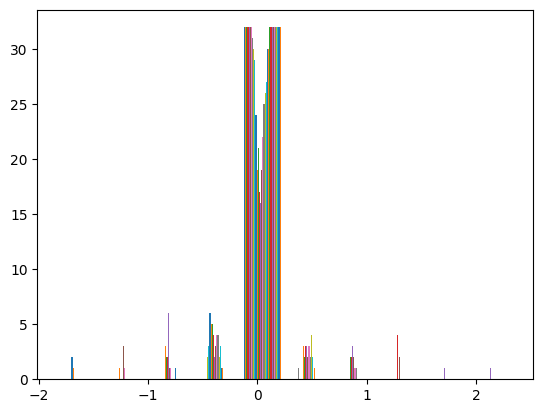

In [14]:
plt.hist(example[0][0][0][0])

In [15]:
def show_slices(image, axis1="x", axis2="y", axis3="z"):
    slice_0 = image[round(len(image[0])/2), :, :]
    slice_1 = image[:, round(len(image[1])/2), :]
    slice_2 = image[:, :, round(len(image[2])/2)]
    image = ([slice_0, slice_1, slice_2])
    fig, axes = plt.subplots(1, len(image), figsize=[15,15])
    for i, slice in enumerate(image):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[0].set(xlabel=axis2, ylabel=axis3)
        axes[1].set(xlabel=axis1, ylabel=axis3)
        axes[2].set(xlabel=axis1, ylabel=axis2)
    plt.show()

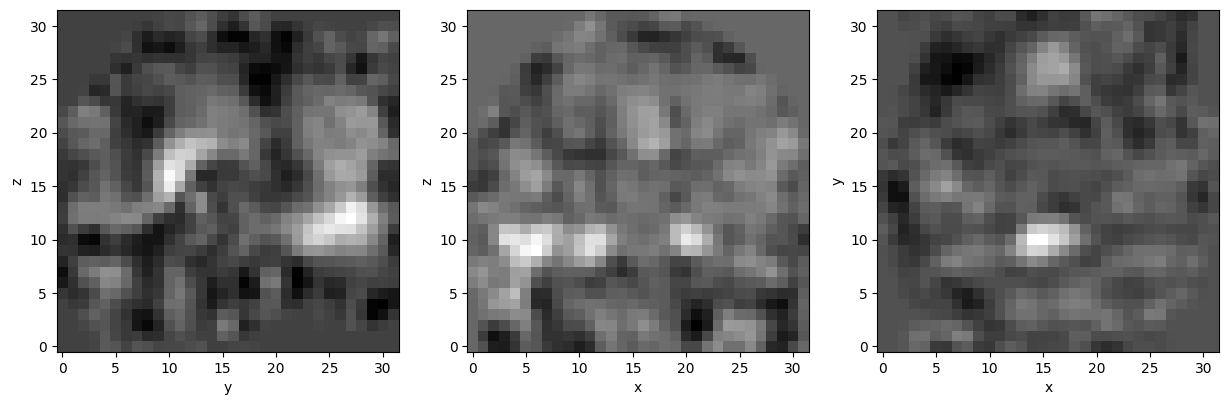

In [16]:
show_slices(example[0][0][0])

In [17]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConvEncoder(nn.Module):
    def __init__(self, in_channels=1,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="prelu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 is_rcnn=False):
        super(ConvEncoder, self).__init__()
        self.is_rcnn =is_rcnn
        convs =[]
        for out_channels in out_channels_list:
            if network_type =="Residual":
                conv = ResidualUnit(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            else:
                conv = Convolution(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            in_channels =out_channels
            convs.append(conv)
            
        self.conv_layer =nn.Sequential(*convs)
        input_shape = np.array(input_shape)
        self.n_flatten_units = int(np.prod(input_shape // (2 ** len(out_channels_list))) * out_channels)
        self.faltten = Flatten()
        
    def forward(self, x):
        if self.is_rcnn:
            n_objects, seq_length = x.size()[0:2]
            x = x.reshape([n_objects * seq_length] + list(x.size()[2:]))
            x = torch.unsqueeze(x, axis=1)
            x = self.conv_layer(x)
            x =self.faltten(x)
            x = x.reshape([n_objects, seq_length, -1])
        else:
            x = self.conv_layer(x)
            x =self.faltten(x)
        return x        

In [18]:
class ClfGRU(nn.Module):
    def __init__(self, n_latent_units, seq_length, 
                 hidden_size=128, n_layers=1,
                use_states="last"):
        super(self.__class__, self).__init__()
        self.n_latent_units = n_latent_units
        self.seq_length = seq_length
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            n_latent_units, 
            hidden_size, n_layers, 
            batch_first=True
        )
        
        self.use_states = use_states
        if use_states == "last":
            self.gru_out_size = hidden_size
        elif use_states == "mean":
            self.gru_out_size = hidden_size
        elif use_states == "all":
            self.gru_out_size = hidden_size * seq_length
            
    def forward(self, x):
        out, _ = self.gru(x)
        
        if self.use_states == "last":
            out = out[:, -1, :]
        elif self.use_states == "mean":
            out = out.mean(dim=1)
        elif self.use_states == "all":
            out = out.reshape(n_objects, self.hidden_size * seq_length)
        
        return out

In [19]:
class FMRINET(nn.Module):
    def __init__(self, in_channels=10,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="relu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 n_outputs =2,
                 n_fc_units=128,
                 hidden_size=128,
                 dropout =0.2,
                 n_layers=1,
                 is_rcnn=False):
        super(FMRINET, self).__init__()
        self.is_rcnn=is_rcnn
        if self.is_rcnn:
            self.cnn =ConvEncoder(in_channels=1,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=True)
            self.gru =ClfGRU(self.cnn.n_flatten_units, 
                             in_channels,hidden_size=hidden_size,n_layers=n_layers)
            self.fc =nn.Sequential(
                               # nn.Dropout(dropout),
                               nn.Linear(self.gru.gru_out_size, n_fc_units),
                               nn.ReLU(inplace=True),
                               # nn.Linear(n_fc_units, n_fc_units),
                               # nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
            
        else:
            self.cnn =ConvEncoder(in_channels=in_channels,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=False)
            self.fc =nn.Sequential(
                               # nn.Dropout(dropout),
                               nn.Linear(self.cnn.n_flatten_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               # nn.Linear(n_fc_units, n_fc_units),
                               # nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
        
    def forward(self,x):
        if self.is_rcnn:
            x =self.cnn(x)
            x =self.gru(x)
            x =self.fc(x)
        else:
            x =self.cnn(x)
            x =self.fc(x)
        return x    

In [20]:
model =FMRINET( out_channels_list=[8, 16, 32, 64],
                 in_channels=30,
                 n_fc_units=64,
                 hidden_size=64,
                 input_shape=(32, 32, 32),
                 dropout =0.1,is_rcnn=True)

In [21]:
model.cnn.n_flatten_units

512

In [22]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
# model = monai.networks.nets.DenseNet121(in_channels=30,spatial_dims=3, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data
#weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# start a typical PyTorch training
val_interval = 1
best_metric = -1
best_metric_epoch = -1  
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 40

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    num_correct = 0.0
    metric_count = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        
        value = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
        metric_count += len(value)
        num_correct += value.sum().item()
                
        # print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    metric = num_correct / metric_count
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    print(f"Current epoch: {epoch+1} current train accuracy: {metric:.4f} ")
    writer.add_scalar("train_accuracy", metric, epoch + 1)
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += value.sum().item()

            metric = num_correct / metric_count
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")

            print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/40
epoch 1 average loss: 0.6989
Current epoch: 1 current train accuracy: 0.5492 
saved new best metric model
Current epoch: 1 current accuracy: 0.4667 
Best accuracy: 0.4667 at epoch 1
----------
epoch 2/40
epoch 2 average loss: 0.6795
Current epoch: 2 current train accuracy: 0.5902 
Current epoch: 2 current accuracy: 0.3667 
Best accuracy: 0.4667 at epoch 1
----------
epoch 3/40
epoch 3 average loss: 0.6692
Current epoch: 3 current train accuracy: 0.6066 
saved new best metric model
Current epoch: 3 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 3
----------
epoch 4/40
epoch 4 average loss: 0.6504
Current epoch: 4 current train accuracy: 0.5820 
Current epoch: 4 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 3
----------
epoch 5/40
epoch 5 average loss: 0.6374
Current epoch: 5 current train accuracy: 0.6967 
Current epoch: 5 current accuracy: 0.5667 
Best accuracy: 0.5667 at epoch 3
----------
epoch 6/40
epoch 6 average loss: 0.6257
Current epoch